In [38]:
import pandas as pd
import numpy as np
import pylab as plt
import glob
import os
import random
import keras
from keras import backend as K
from keras import layers
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential, Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import cv2
from tqdm import tqdm
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from collections import Counter
from sklearn.model_selection import train_test_split
import sklearn
from collections import Counter
from pandas import DataFrame
import gc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

In [51]:
keras.__version__

'2.4.3'

In [2]:
def load_data_local(new_w,new_h):
    train_labels = pd.read_csv(r'C:\Users\aleja\OneDrive\Desktop\Kaggle\Leave Issues Competition\train.csv',sep=',')
    path_loop = r"C:\Users\aleja\OneDrive\Desktop\Kaggle\Leave Issues Competition\train_images\*.*"
    path = r"C:\Users\aleja\OneDrive\Desktop\Kaggle\Leave Issues Competition\train_images"
    onlyfiles = next(os.walk(path))[2] #dir is your directory path as string
    numOfFiles = len(onlyfiles)
    data = []
    for file in tqdm(glob.glob(path_loop)):
        a=cv2.imread(file)
        name_file = os.path.basename(file)
        label = train_labels.loc[train_labels['image_id'] == name_file,'label'].values
        #conversion numpy array into rgb image to show
        c = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        h, w, channels = c.shape
        #input size of Resnet architecture
        frame_rgb = cv2.resize(c,(new_w,new_h),interpolation=cv2.INTER_CUBIC)
        data.append([frame_rgb,label])
    return data

In [3]:
def load_data(new_w,new_h):
    train_labels = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv', sep=',')
    path = '../input/cassava-leaf-disease-classification/train_images'
    path_loop = r'../input/cassava-leaf-disease-classification/train_images/*.*'
    onlyfiles = next(os.walk(path))[2] #dir is your directory path as string
    numOfFiles = len(onlyfiles)
    data = []
    for file in tqdm(glob.glob(path_loop)):
        a=cv2.imread(file)
        name_file = os.path.basename(file)
        label = train_labels.loc[train_labels['image_id'] == name_file,'label'].values
        #conversion numpy array into rgb image to show
        c = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        h, w, channels = c.shape
        #input size of Resnet architecture
        frame_rgb = cv2.resize(c,(new_w,new_h),interpolation=cv2.INTER_CUBIC)
        data.append([frame_rgb,label])
    return data


In [4]:
#Change before submitting to Kaggle from load_data_local to load_data
data = load_data_local(224, 224)

100%|██████████| 21397/21397 [04:03<00:00, 87.76it/s]


In [26]:
classes_test = np.array([[1],[1],[1],[3],[4],[0],[2],[2],[3],[1],[1]])
classes_test_modified = np.concatenate( classes_test, axis=0 )
print(classes_test_modified)
class_weights = compute_class_weight('balanced', np.unique(classes_test_modified), classes_test_modified)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

[1 1 1 3 4 0 2 2 3 1 1]
{0: 2.2, 1: 0.44, 2: 1.1, 3: 1.1, 4: 2.2}


In [5]:
def train_test_split_modified(data):
    x_data = []
    y_data = []
    
    for feature, label in data:
        x_data.append(feature)
        y_data.append(label)
        
    X_data, X_test, Y_data, Y_test = sklearn.model_selection.train_test_split(x_data, y_data, stratify = y_data, test_size=0.1, random_state=42)
    X_model_1, X_aux, Y_model_1, Y_aux = sklearn.model_selection.train_test_split(X_data, Y_data, stratify = Y_data, test_size=0.66, random_state=42)
    X_model_2, X_model_3, Y_model_2, Y_model_3 = sklearn.model_selection.train_test_split(X_aux, Y_aux, stratify = Y_aux, test_size=0.5, random_state=42)
    return X_test, Y_test, X_model_1, Y_model_1, X_model_2, Y_model_2, X_model_3, Y_model_3
    


In [28]:
def data_preparation(X_data, Y_data, new_h, new_w, channels):
    x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,stratify=Y_data, train_size=0.8, random_state=42)
    x_train = np.array(x_train) / 255
    x_val = np.array(x_val) / 255
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    x_train = x_train.reshape(-1, new_h, new_w, channels)
    x_val = x_val.reshape(-1, new_h, new_w, channels)
    y_train = np.concatenate(y_train, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    return x_train, x_val, y_train, y_val

In [31]:
#Encode target variables
def encode_target_variable(y_train,y_val):

    class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
    d_class_weights = dict(enumerate(class_weights))
    print(d_class_weights)
    onehot_encoder = OneHotEncoder(sparse=False)
    y_train = y_train.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    y_train_onehot = onehot_encoder.fit_transform(y_train)
    y_val_onehot = onehot_encoder.fit_transform(y_val)
    return y_train_onehot, y_val_onehot, d_class_weights

In [48]:
def create_model_0(input_shape):
    input_img = Input(shape=input_shape)  
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
    y = Dropout(0.4)(y)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    z = MaxPooling2D((2, 2), padding='same')(z)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(z)
    z = MaxPooling2D((2, 2), padding='same')(z)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(z)

    out = layers.concatenate([x, y, z])
    out = layers.Flatten()(out)
    out = Dense(16, activation='selu')(out)
    out = Dense(5, activation='softmax')(out)
    
    model_f = Model(inputs=[input_img], outputs=[out])
    print(model_f.summary)
    return model_f

In [8]:
def create_model_1(x_train,x_val):
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet50.trainable = False # remove if you want to retrain resnet weights
    resnet50.summary()
    transfer_model_1 = Sequential()
    transfer_model_1.add(resnet50)
    transfer_model_1.add(Flatten())
    transfer_model_1.add(Dense(128, activation='relu'))
    transfer_model_1.add(Dropout(0.2))
    transfer_model_1.add(Dense(5, activation='softmax'))
    x_train_new = x_train
    x_val_new = x_val
    x_train_new = keras.applications.resnet50.preprocess_input(x_train_new)
    x_val_new = keras.applications.resnet50.preprocess_input(x_val_new)
    return transfer_model_1, x_train_new, x_val_new

In [9]:
def create_model_2(x_train,x_val):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg16.trainable = False # remove if you want to retrain vgg16 weights
    vgg16.summary()
    transfer_model_2 = Sequential()
    transfer_model_2.add(vgg16)
    transfer_model_2.add(Flatten())
    transfer_model_2.add(Dense(128, activation='relu'))
    transfer_model_2.add(Dropout(0.2))
    transfer_model_2.add(Dense(5, activation='softmax'))
    x_train_new = x_train
    x_val_new = x_val
    x_train_new = VGG16.preprocess_input(x_train_new)
    x_val_new = VGG16.preprocess_input(x_val_new)
    return transfer_model_2, x_train_new, x_val_new

In [10]:
def create_model_3(x_train,x_val):
    inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    inceptionV3.trainable = False # remove if you want to retrain rinceptionV3 weights
    inceptionV3.summary()
    transfer_model_3 = Sequential()
    transfer_model_3.add(inceptionV3)
    transfer_model_3.add(Flatten())
    transfer_model_3.add(Dense(128, activation='relu'))
    transfer_model_3.add(Dropout(0.2))
    transfer_model_3.add(Dense(5, activation='softmax'))
    x_train_new = x_train
    x_val_new = x_val
    x_train_new = InceptionV3.preprocess_input(x_train_new)
    x_val_new = InceptionV3.preprocess_input(x_val_new)
    return transfer_model_3, x_train_new, x_val_new

In [11]:
def train_model(model, batch_size, epochs, x_train_new, x_val_new, y_train_onehot, y_val_onehot,class_weights):
    
    batch_size = batch_size
    epochs = epochs
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['categorical_accuracy',keras.metrics.AUC(),keras.metrics.Recall()])
    
    
    history = model.fit(x_train_new, y_train_onehot, \
                              batch_size=batch_size, epochs=epochs, \
                              validation_split=0.2, verbose=1, shuffle=True, validation_data=(x_val_new, y_val_onehot),
                       class_weight = class_weights)
    return model

C:\Users\aleja\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\Users\aleja\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2 3 4], y=[2 1 3 ... 3 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 3.937593984962406, 1: 1.9541044776119403, 2: 1.7934931506849314, 3: 0.32517851598882336, 4: 1.6625396825396825}
<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x0000026B96F1BAF0>>
Epoch 1/10
9/9 [==============================] - 211s 23s/step - loss: 12.3099 - categorical_accuracy: 0.3605 - auc_2: 0.6379 - recall_2: 0.3324 - val_loss: 1.2181 - val_categorical_accuracy: 0.6069 - val_auc_2: 0.7743 - val_recall_2: 0.5849
Epoch 2/10
9/9 [==============================] - 221s 25s/step - loss: 1.1675 - categorical_accuracy: 0.6158 - auc_2: 0.8045 - recall_2: 0.5986 - val_loss: 1.2625 - val_categorical_accuracy: 0.6069 - val_auc_2: 0.7923 - val_recall_2: 0.6069
Epoch 3/10
9/9 [==============================] - 241s 27s/step - loss: 1.1573 - categorical_accuracy: 0.6200 - auc_2: 0.8152 - recall_2: 0.5773 - val_loss: 1.5013 - val_categorical_accuracy: 0.6069 - val_auc_2: 0.7862 - val_recall_2: 0.6069
Epoch 4/10
9/9 [=========================

TypeError: cannot unpack non-iterable Functional object

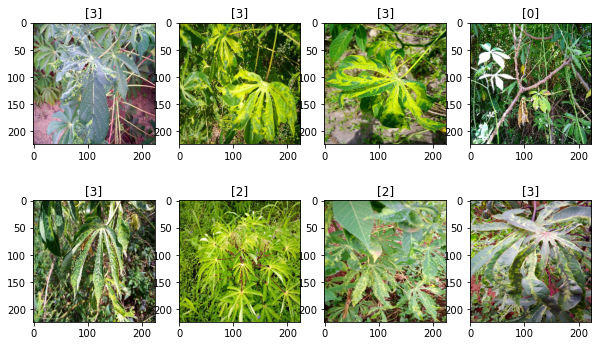

In [49]:
################## Main function ######################


new_h = 224
new_w = 224
batch_size = 500
epochs = 10
channels = 3
#Divide data into test and training/validation for three different models
X_test, Y_test, X_model_1, Y_model_1, X_model_2, Y_model_2, X_model_3, Y_model_3 = train_test_split_modified(data)
training_data = [X_model_1, Y_model_1, X_model_2, Y_model_2, X_model_3, Y_model_3]
#Check that the training datasets are correctly stratified 
Y_model_1_df = DataFrame(Y_model_1,columns=['labels'])
#print(Y_model_1_df.labels.value_counts())
Y_model_2_df = DataFrame(Y_model_2,columns=['labels'])
#print(Y_model_2_df.labels.value_counts())
Y_model_3_df = DataFrame(Y_model_3,columns=['labels'])
#print(Y_model_3_df.labels.value_counts())
#deaseases explanation: {"0": "Cassava Bacterial Blight (CBB)", 
#"1": "Cassava Brown Streak Disease (CBSD)", "2": "Cassava Green Mottle (CGM)", 
#"3": "Cassava Mosaic Disease (CMD)", "4": "Healthy"}

#visualize each of the classes
fig = plt.figure(figsize=(10, 6))

for i in range(8):
    img = X_model_1[i]
    fig.add_subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(Y_model_1[i])
    
#Baseline model
x_train, x_val, y_train, y_val = data_preparation(training_data[0], training_data[1], new_h, new_w, channels)
y_train_onehot, y_val_onehot, class_weights = encode_target_variable(y_train,y_val)
input_shape = [new_h,new_w,channels]
del y_train, y_val
baseline_model = create_model_0(input_shape)
gc.collect()
baseline_model = train_model(baseline_model, batch_size, epochs, x_train, x_val, y_train_onehot, y_val_onehot)
#Resnet50
x_train, x_val, y_train, y_val = data_preparation(training_data[0], training_data[1], new_h, new_w, channels)
y_train_onehot, y_val_onehot, class_weights = encode_target_variable(y_train,y_val)
del y_train, y_val
resnet50_model, x_train_new, x_val_new = create_model_1(x_train,x_val)
del x_train,x_val
gc.collect()
resnet50_model = train_model(resnet50_model, batch_size, epochs, x_train_new, x_val_new, y_train_onehot, y_val_onehot)
#vgg16
x_train, x_val, y_train, y_val = data_preparation(training_data[2], training_data[3], new_h, new_w, channels)
y_train_onehot, y_val_onehot = encode_target_variable(y_train,y_val)
del y_train, y_val
vgg16_model, x_train_new, x_val_new = create_model_2(x_train,x_val)
del x_train,x_val
gc.collect()
vgg16_model = train_model(vgg16_model, batch_size, epochs, x_train_new, x_val_new, y_train_onehot, y_val_onehot)
#InceptionV3
x_train, x_val, y_train, y_val = data_preparation(training_data[4], training_data[5], new_h, channels)
y_train_onehot, y_val_onehot = encode_target_variable(y_train,y_val)
del y_train, y_val
inception_model, x_train_new, x_val_new = create_model_3(x_train,x_val)
del x_train,x_val
gc.collect()
inception_model = train_model(inception_model, batch_size, epochs, x_train_new, x_val_new, y_train_onehot, y_val_onehot)